In [1]:
%load_ext autotime
from deltalake import DeltaTable
import numpy as np
import pandas as pd

bets = DeltaTable("/Users/andreikirpichev/parquet/bets_oct_pers/")
bets = bets.to_pandas()
bets.sort_values('placement_time', ascending=True, inplace=True)
#bets['placement_time'] = bets['placement_time'].view('int64')
#bets['back'] = pd.to_datetime(bets["placement_time"])
#top_customers = bets["customer_id"].value_counts().index.tolist()
#bets = bets[bets['customer_id'].isin(top_customers)]
allcolumns = bets.columns.tolist()

test_betmarkets = DeltaTable("/Users/andreikirpichev/parquet/test_betmarkets_grouped/")
test_betmarkets = test_betmarkets.to_pandas()
#test_betmarkets['start'] = test_betmarkets['start'].view('int64')
#test_betmarkets['end'] = test_betmarkets['end'].view('int64')
bets.head()

bet_keys = ["section", "point", "market"]
test_betmarkets["betmarket_id"] = test_betmarkets.groupby(test_betmarkets[bet_keys].apply(frozenset, axis=1)).ngroup() + 1

match_keys = ["region", "league"]
test_betmarkets["match_id"] = test_betmarkets.groupby(test_betmarkets[match_keys].apply(frozenset, axis=1)).ngroup() + 1

time: 29.6 s (started: 2023-05-11 16:07:58 +02:00)


In [2]:
betmarket_categorical_features = ['section', 'point', 'market', 'league', 'region']#, 'contest_id', 'league', 'region', 'home', 'away']
categorical_features = betmarket_categorical_features + ['country'] #'customer_id'

#betmarket_passthrough_feats = ['start', 'end', 'placement_odds']
#passthrough_feats = ['age', 'placement_odds', 'minutes_before_start', 'placement_time', 'stake_eur', 'weekday_stake', '2w_section', '2w_point', '2w_market']

features = categorical_features + ['age', 'minutes_before_start', '2w_section', '2w_point', '2w_market', '2w_region', '2w_league'] #'placement_odds',
features_meta = features + ['placement_time', 'customer_id', 'weekday_stake']#, '2w_section', '2w_point', '2w_market']

ohf = {
    "point": 3,
    "section": 10,
    "market": 10,
    "league": 30,
    "region": 30,
    #"country": 30,
}

def ohefeatures(df, feautures_dict):
    res = []
    for col, n in feautures_dict.items():
        res = res + [col + '_' + v for v in df[col].value_counts().head(n).index.tolist()]
    return res

def intersection(lst1, lst2):
    lst3 = [value for value in lst1 if value in lst2]
    return lst3
ohfeats = intersection(ohefeatures(bets, ohf), ohefeatures(test_betmarkets, ohf))
def dummies(df, columns):
    prev_cols = df.columns.tolist()
    dummied = pd.get_dummies(df,columns=columns)
    dummied_full = pd.concat([df[columns], dummied], axis=1)
    dummy_feats = [f for f in dummied.columns if f.startswith("country")]
    filtered = dummied_full[prev_cols + ohfeats + dummy_feats]
    return filtered

bets = dummies(bets, categorical_features)
test_betmarkets = dummies(test_betmarkets, betmarket_categorical_features)

def minuslist(li1, li2):
    s = set(li2)
    return [x for x in li1 if x not in s]
notrain = minuslist(allcolumns, features)
features_with_dummies_orig = minuslist(bets.columns.tolist(), notrain)
features = minuslist(features_with_dummies_orig, categorical_features)
print(len(features), features)

60 ['age', 'minutes_before_start', '2w_section', '2w_point', '2w_market', '2w_region', '2w_league', 'point_Goal', 'point_Corner', 'point_RedCard', 'section_RT', 'section_HT1', 'section_HT2', 'section_LT', 'section_FT', 'market_OverUnder', 'market_Handicap3w', 'market_BothTeamsToScore', 'market_NthPoint', 'market_TeamOverUnder', 'market_PlayerToScore', 'market_TeamToScore', 'market_CorrectScore', 'market_Handicap2w', 'league_Bundesliga', 'league_Cup', 'league_Championship', 'league_Eredivisie', 'region_EUR', 'region_DE', 'region_ENG', 'region_ES', 'region_IT', 'region_FR', 'region_TR', 'region_AR', 'region_NL', 'region_BE', 'region_PT', 'region_BR', 'region_AT', 'region_NO', 'region_DK', 'region_JP', 'region_MX', 'region_CZ', 'region_SE', 'region_KR', 'region_CO', 'region_RO', 'region_PL', 'region_CN', 'region_CL', 'country_AT', 'country_CA', 'country_DE', 'country_FI', 'country_IN', 'country_LU', 'country_MT']
time: 44.5 s (started: 2023-05-11 16:08:28 +02:00)


In [3]:
# Create features and target
X = bets#[features_meta]
y = bets['stake_eur']

# show rows with NaN values
#print(X[X.isna().any(axis=1)])

# Make necessary imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 101, shuffle=False)

print('train: from', X_train['placement_time'].min(), ' to ', X_train['placement_time'].max(), X_train.shape)
print('test: from', X_test['placement_time'].min(), ' to ', X_test['placement_time'].max(), X_test.shape)
threshhold = X_train['placement_time'].max()
X_train = X_train[features]

# Train the model
#regr = RandomForestRegressor(n_estimators = 10, max_depth = 10, random_state = 101)
#regr.fit(X_train, y_train.values.ravel())

train: from 2022-10-01 00:00:29.446000  to  2022-10-22 22:50:28.562000 (1722131, 302)
test: from 2022-10-22 22:50:28.562000  to  2022-10-28 14:23:42.051000 (430533, 302)
time: 6.71 s (started: 2023-05-11 16:09:12 +02:00)


In [ ]:
from sklearn.svm import SVR
regr = SVR(C=1.0, epsilon=0.2).fit(X_train, y_train.values.ravel())

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Make prediction
#print(X_test[features].columns.tolist(), X_test[features])
predictions = regr.predict(X_test[features])
baselinePredictions = X_test['weekday_stake']

result = X_test[:]
result['stake_eur'] = y_test
result['prediction'] = predictions.tolist()
result['baseline_prediction'] = baselinePredictions.tolist()
result.head()

,customer_id,age,country,section,point,market,contest_id,placement_date,placement_time,placement_odds,...,region_CL,country_AT,country_CA,country_DE,country_FI,country_IN,country_LU,country_MT,prediction,baseline_prediction
389932,17715410,35,DE,RT,Goal,Handicap3w,FB-204582,2022-10-22,2022-10-22 22:50:28.562,1.74,...,0,0,0,1,0,0,0,0,2.283709,2.99
389928,17715410,35,DE,RT,Goal,ToScoreEachSection,FB-204617,2022-10-22,2022-10-22 22:50:28.562,1.58,...,0,0,0,1,0,0,0,0,2.884760,2.80
620583,16736910,45,DE,RT,Goal,OverUnder,FB-214682,2022-10-22,2022-10-22 22:50:30.978,4.50,...,0,0,0,1,0,0,0,0,4.591636,4.48
2032409,4869710,45,DE,RT,Goal,Handicap3w,FB-214710,2022-10-22,2022-10-22 22:50:33.189,1.49,...,0,0,0,1,0,0,0,0,5.165867,3.59
2032410,4869710,45,DE,RT,Goal,Handicap3w,FB-214011,2022-10-22,2022-10-22 22:50:33.189,1.76,...,0,0,0,1,0,0,0,0,4.326453,3.76


time: 488 ms (started: 2023-05-11 13:57:08 +02:00)


In [7]:
# Import library for metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# Mean absolute error (MAE)
mae = mean_absolute_error(y_test.values.ravel(), predictions)
maeB = mean_absolute_error(y_test.values.ravel(), baselinePredictions)
# Mean squared error (MSE)
mse = mean_squared_error(y_test.values.ravel(), predictions)
mseB = mean_squared_error(y_test.values.ravel(), baselinePredictions)
# R-squared scores
r2 = r2_score(y_test.values.ravel(), predictions)
r2B = r2_score(y_test.values.ravel(), baselinePredictions)

# Print metrics
print('Mean Absolute Error:', round(mae, 2), 'baseline:', round(maeB, 2))
print('Mean Squared Error:', round(mse, 2), 'baseline:', round(mseB, 2))
print('R-squared scores:', round(r2, 2), 'baseline:', round(r2B, 2))

Mean Absolute Error: 2.74 baseline: 3.56
Mean Squared Error: 312.93 baseline: 409.77
R-squared scores: 0.69 baseline: 0.59
time: 8.47 ms (started: 2023-05-11 13:57:15 +02:00)


In [9]:
# Get features list
characteristics = regr.feature_names_in_ # X_train.columns
# Get the variables importances, sort them, and print the result
importances = list(regr.feature_importances_)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: 2w_league            Importance: 0.88
Variable: 2w_region            Importance: 0.03
Variable: 2w_point             Importance: 0.02
Variable: 2w_market            Importance: 0.02
Variable: age                  Importance: 0.01
Variable: minutes_before_start Importance: 0.01
Variable: 2w_section           Importance: 0.01
Variable: point_Goal           Importance: 0.0
Variable: point_Corner         Importance: 0.0
Variable: point_RedCard        Importance: 0.0
Variable: section_RT           Importance: 0.0
Variable: section_HT1          Importance: 0.0
Variable: section_HT2          Importance: 0.0
Variable: section_LT           Importance: 0.0
Variable: section_FT           Importance: 0.0
Variable: market_OverUnder     Importance: 0.0
Variable: market_Handicap3w    Importance: 0.0
Variable: market_BothTeamsToScore Importance: 0.0
Variable: market_NthPoint      Importance: 0.0
Variable: market_TeamOverUnder Importance: 0.0
Variable: market_PlayerToScore Importance: 0.0
Var

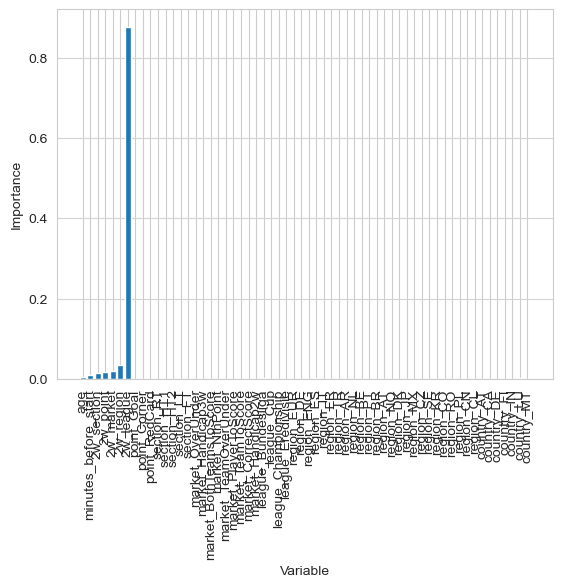

time: 998 ms (started: 2023-05-11 13:57:42 +02:00)


In [10]:
# Import library for visualization
import matplotlib.pyplot as plt
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()

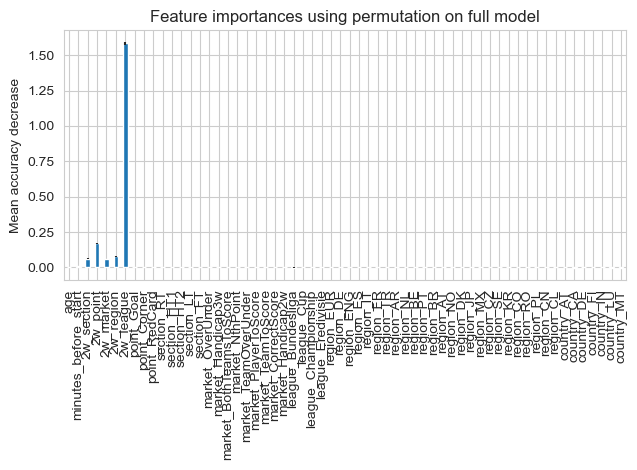

time: 1min 34s (started: 2023-05-11 13:58:01 +02:00)


In [11]:
from sklearn.inspection import permutation_importance
result = permutation_importance(
    regr, X_test[features], y_test, n_repeats=10, random_state=42, n_jobs=2
)
forest_importances = pd.Series(result.importances_mean, index=[i for i in X_test[features].columns])
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [14]:
characteristics = regr.feature_names_in_
# Get the variables importances, sort them, and print the result
importances = list(result.importances_mean)
characteristics_importances = [(characteristic, round(importance, 2)) for characteristic, importance in zip(characteristics, importances)]
characteristics_importances = sorted(characteristics_importances, key = lambda x: x[1], reverse = True)
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in characteristics_importances];

Variable: 2w_league            Importance: 1.58
Variable: 2w_point             Importance: 0.17
Variable: 2w_region            Importance: 0.08
Variable: 2w_section           Importance: 0.06
Variable: 2w_market            Importance: 0.06
Variable: minutes_before_start Importance: 0.01
Variable: age                  Importance: 0.0
Variable: point_Goal           Importance: -0.0
Variable: point_Corner         Importance: 0.0
Variable: point_RedCard        Importance: 0.0
Variable: section_RT           Importance: 0.0
Variable: section_HT1          Importance: 0.0
Variable: section_HT2          Importance: 0.0
Variable: section_LT           Importance: 0.0
Variable: section_FT           Importance: 0.0
Variable: market_OverUnder     Importance: -0.0
Variable: market_Handicap3w    Importance: 0.0
Variable: market_BothTeamsToScore Importance: 0.0
Variable: market_NthPoint      Importance: -0.0
Variable: market_TeamOverUnder Importance: 0.0
Variable: market_PlayerToScore Importance: 0.0
V

In [12]:
# Import GridSearchCV
from sklearn.model_selection import GridSearchCV

# Find the best parameters for the model
parameters = {
    'max_depth': [70, 80, 90, 100],
    'n_estimators': [900, 1000, 1100]
}
gridforest = GridSearchCV(regr, parameters, cv = 3, n_jobs = -1, verbose = 1)
gridforest.fit(X_train, y_train)
gridforest.best_params_
# Import library for visualization
import matplotlib.pyplot as plt
# Visualize the variables importances
plt.bar(characteristics, importances, orientation = 'vertical')
plt.xticks(rotation = 'vertical')
plt.ylabel('Importance')
plt.xlabel('Variable')
plt.grid(axis = 'y', color = '#D3D3D3', linestyle = 'solid')
plt.show()

Fitting 3 folds for each of 12 candidates, totalling 36 fits


Traceback (most recent call last):
  File "/Users/andreikirpichev/opt/anaconda3/lib/python3.9/runpy.py", line 188, in _run_module_as_main
    mod_name, mod_spec, code = _get_module_details(mod_name, _Error)
  File "/Users/andreikirpichev/opt/anaconda3/lib/python3.9/runpy.py", line 111, in _get_module_details
    __import__(pkg_name)
  File "/Users/andreikirpichev/opt/anaconda3/lib/python3.9/site-packages/joblib/__init__.py", line 113, in <module>
    from .memory import Memory, MemorizedResult, register_store_backend
  File "/Users/andreikirpichev/opt/anaconda3/lib/python3.9/site-packages/joblib/memory.py", line 32, in <module>
    from ._store_backends import StoreBackendBase, FileSystemStoreBackend
  File "/Users/andreikirpichev/opt/anaconda3/lib/python3.9/site-packages/joblib/_store_backends.py", line 15, in <module>
    from .backports import concurrency_safe_rename
  File "/Users/andreikirpichev/opt/anaconda3/lib/python3.9/site-packages/joblib/backports.py", line 125, in <module>


KeyboardInterrupt: 

time: 2.53 s (started: 2023-05-11 13:30:40 +02:00)


In [11]:
pd.options.mode.chained_assignment = None
shuffled = X_test[:].sample(frac=1)
progress = 0
pred_sum = 0
base_sum = 0
buf = pd.DataFrame({'betmarket_ids': pd.Series(dtype='str')})
for index, row in shuffled.head(1000).iterrows():
    buf.at[index, "betmarket_ids"] = test_betmarkets.index[(test_betmarkets['start'] <= row['placement_time']) &
                                         (test_betmarkets['end'] >= row['placement_time'])].tolist()
shuffled["betmarket_ids"] = buf["betmarket_ids"]

time: 16.7 s (started: 2023-05-09 23:59:07 +02:00)


In [13]:
k = shuffled["section"]
k.head(1)
#k.value_counts()

1743232    RT
Name: section, dtype: object

time: 3.68 ms (started: 2023-05-09 20:53:28 +02:00)


In [10]:
regr.feature_names_in_

array(['age', 'minutes_before_start', '2w_section', '2w_point',
       '2w_market', 'point_Goal', 'point_Corner', 'point_RedCard',
       'section_RT', 'section_HT1', 'section_HT2', 'section_LT',
       'section_FT', 'market_OverUnder', 'market_Handicap3w',
       'market_BothTeamsToScore', 'market_NthPoint',
       'market_TeamOverUnder', 'market_PlayerToScore',
       'market_TeamToScore', 'market_CorrectScore', 'market_Handicap2w',
       'league_Bundesliga', 'league_Cup', 'league_Championship',
       'league_Eredivisie', 'region_EUR', 'region_DE', 'region_ENG',
       'region_ES', 'region_IT', 'region_FR', 'region_TR', 'region_AR',
       'region_NL', 'region_BE', 'region_PT', 'region_BR', 'region_AT',
       'region_NO', 'region_DK', 'region_JP', 'region_MX', 'region_CZ',
       'region_SE', 'region_KR', 'region_CO', 'region_RO', 'region_PL',
       'region_CN', 'region_CL', 'country_AT', 'country_CA', 'country_DE',
       'country_FI', 'country_IN', 'country_LU', 'country_MT'],


time: 1.36 ms (started: 2023-05-11 12:34:54 +02:00)


In [16]:
print([f for f in X_train.columns if
       (not f.startswith("section_")) &
       (not f.startswith("market_")) &
       (not f.startswith("point_")) &
       (not f.startswith("league_")) &
       (not f.startswith("region_"))
       ])

['age', 'placement_odds', 'minutes_before_start', '2w_section', '2w_point', '2w_market']
time: 3.51 ms (started: 2023-05-09 20:55:43 +02:00)


In [13]:
test_betmarkets[['age', 'placement_odds', 'minutes_before_start', '2w_section', '2w_point', '2w_market']].head()

KeyError: "['age', 'minutes_before_start', '2w_section', '2w_point', '2w_market'] not in index"

time: 52.7 ms (started: 2023-05-09 23:59:24 +02:00)


In [15]:
customer_bet_features = ['age', 'minutes_before_start'] + [f for f in regr.feature_names_in_ if f.startswith("country_")]
customer_bet_features

['age',
 'minutes_before_start',
 'country_AT',
 'country_CA',
 'country_DE',
 'country_FI',
 'country_IN',
 'country_LU',
 'country_MT']

time: 2.73 ms (started: 2023-05-11 14:05:11 +02:00)


In [61]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

time: 4.21 ms (started: 2023-05-10 16:06:43 +02:00)


In [44]:
pd.options.mode.chained_assignment = None
size = 1
shuffled = X_test[:].sample(frac=1)
progress=0

for index, row in shuffled.head(size).iterrows():
    current_betmarkets = test_betmarkets[(test_betmarkets['start'] <= row['placement_time']) &
                                         (test_betmarkets['end'] >= row['placement_time'])]

    #current_betmarkets = test_betmarkets.filter(items=row["betmarket_ids"])
    current_betmarkets[customer_bet_features] = row[customer_bet_features]
    # bets_2w = bets[(bets['placement_time'] > row['placement_time'] - np.timedelta64(14,'D')) &
    #                (bets['placement_time'] < row['placement_time'])]
    for f in betmarket_categorical_features:
        feature_header = '2w_' + f
        current_betmarkets[feature_header] = 'pers_' + f + '_' + current_betmarkets[f].astype(str)
        current_betmarkets[feature_header] = current_betmarkets[feature_header].map(row.to_dict()).fillna(0)

    c = ['2w_' + f for f in betmarket_categorical_features]
    current_betmarkets_truncated = current_betmarkets.drop_duplicates(['betmarket_id', 'match_id'])
    predictions = regr.predict(current_betmarkets_truncated[features])
    current_betmarkets_truncated['prediction'] = predictions.tolist()
    # print(len(current_betmarkets_truncated[['betmarket_id', 'match_id']].value_counts().index))
    print('weekday_stake:', row['weekday_stake'])
    print(current_betmarkets_truncated['prediction'].value_counts())
    current_betmarkets_truncated.sort_values("prediction", ascending=False, inplace=True)
    print(current_betmarkets_truncated.head(10))
    for param in betmarket_categorical_features:
        for i in range(1, 10):
            shuffled.at[index, 'prediction'+str(i)+ '_' + param] = current_betmarkets_truncated[param].iloc[i]

    progress += 1
    if progress % 50 == 0:
        print("processed ", round(progress / size * 100, 2), "%")
    # current_betmarkets_truncated[[f for f in current_betmarkets_truncated.columns if not f.startswith("region_") and not f.startswith("league_") and not f.startswith("section_") and not f.startswith("point_") and not f.startswith("market_")]]\
    #     .sort_values('prediction', ascending=False)
shuffled.head(3)

    #current_betmarkets['prediction'] = predictions.tolist()
    #current_betmarkets.sort_values('a', ascending=False)
    #recommended = current_betmarkets.query('prediction == prediction.max()')
    #model_predicted = recommended.iloc[0]

    # progress += 1
    # if progress % 50 == 0:
    #     print("processed ", round(progress / size * 100, 2), "%")

weekday_stake: 1.15
0.047660    2866
0.481381     113
0.508441      91
Name: prediction, dtype: int64
      contest_id section point                  market                 away  \
19698  FB-234676     HT1  Goal           TeamOverUnder    Red Bull Salzburg   
23077  FB-219470      RT  Goal    HigherScoringSection              SV Ried   
23113  FB-219470      RT  Goal  TeamToScoreEachSection              SV Ried   
19738  FB-234676      RT  Goal            CorrectScore    Red Bull Salzburg   
19737  FB-234676      RT  Goal        BothTeamsToScore    Red Bull Salzburg   
19735  FB-234676     HT2  Goal             TeamToScore    Red Bull Salzburg   
19732  FB-234676     HT2  Goal           TeamOverUnder    Red Bull Salzburg   
19731  FB-234676     HT2  Goal  PrecombinedBettingType    Red Bull Salzburg   
87112  FB-220166      RT  Goal  PrecombinedBettingType  WSG Swarovski Tirol   
19728  FB-234676     HT2  Goal               OverUnder    Red Bull Salzburg   

                        star

,customer_id,age,country,section,point,market,contest_id,placement_date,placement_time,placement_odds,...,prediction9_league,prediction1_region,prediction2_region,prediction3_region,prediction4_region,prediction5_region,prediction6_region,prediction7_region,prediction8_region,prediction9_region
2096637,9135810,46,DE,HT1,Goal,NthPoint,FB-219286,2022-10-24,2022-10-24 23:26:04.665,3.80,...,Bundesliga,AT,AT,AT,AT,AT,AT,AT,AT,AT
1655959,14537910,41,DE,RT,Goal,OverUnder,FB-211733,2022-10-27,2022-10-27 10:07:31.938,1.86,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1974082,17376610,54,DE,RT,Goal,Handicap3w,FB-208134,2022-10-25,2022-10-25 19:38:29.242,1.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


time: 2.75 s (started: 2023-05-11 15:12:35 +02:00)


In [41]:
segment = "prediction" #recent
n = 9
def header(i):
    return segment + str(i) + '_' + param
bets1 = shuffled[:]

res = 0

for param in betmarket_categorical_features:

    cols = [param] +\
           [header(i) for i in range(1,n+1)] +\
           ['precision_' + header(i) for i in range(1,n+1)]

    for i in range (1, n + 1):
        str_i = str(i)
        bets1[header(i) + '_rel'] = np.where(bets1[header(i)] == bets1[param], 1, 0)
        bets1['rel_acc_' + header(i)] = sum([bets1[header(j) + '_rel'] for j in range (1, i + 1)])
        bets1['precision_' + header(i)] = sum([np.where(bets1[header(j)] == bets1[param], bets1['rel_acc_' + header(j)] / j, 0) for j in range(1, i + 1)]) / i

    param_avg = bets1['precision_' + segment + str(n) + '_' + param].mean()
    res += param_avg
    print("{}: {}".format(param, param_avg))

print("Result: ", res/5)

section: 0.0006443078957651975
point: 0.0011051760741292878
market: 0.0003288443649383848
league: 0.0001042698761185691
region: 0.00012383802873343358
Result:  0.0004612872479369745
time: 2.75 s (started: 2023-05-11 14:46:26 +02:00)


In [3]:
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import make_column_transformer
# xxx
#
# # Convert the variables to numerical
# def oh_encode(arr, cat_features, pt_features):
#     all = pt_features + cat_features
#     transformer = make_column_transformer(
#         (OneHotEncoder(), cat_features),
#         ("passthrough", all))
#     transformed = transformer.fit_transform(arr[all])
#     print(transformed)
#     one_hot_features = transformer.named_transformers_["onehotencoder"].get_feature_names_out()
#
#     transformed_df = pd.DataFrame(transformed, columns=all+list(one_hot_features))
#     return transformed_df, one_hot_features
#
# b1, bf = oh_encode(bets, categorical_features, passthrough_feats)
# b1.head()
#
#
#
# # Convert the variables to numerical
# def encode(arr, cat_features, pt_features):
#     all = pt_features + cat_features
#     transformer = make_column_transformer(
#         (OneHotEncoder(), cat_features),
#         ("passthrough", all))
#     transformed = transformer.fit_transform(arr[all]).toarray()
#     print(transformed.shape)
#     one_hot_features = transformer.named_transformers_["onehotencoder"].get_feature_names_out()
#
#     transformed_df = pd.DataFrame(transformed, columns=all+list(one_hot_features))
#     #merged = pd.concat([arr, transformed_df], axis=1)
#     return transformed_df, one_hot_features
#     #arr[features] = pd.DataFrame(transformed, columns=transformer.get_feature_names())
#
# test_betmarkets, test_betmarkets_one_hot_features = encode(test_betmarkets, betmarket_categorical_features, betmarket_passthrough_feats)
# bets, bets_one_hot_features = encode(bets, categorical_features, passthrough_feats)

NameError: name 'xxx' is not defined

time: 116 ms (started: 2023-05-10 12:29:35 +02:00)


In [16]:
pd.options.mode.chained_assignment = None
size = 100
#shuffled = X_test[:].sample(frac=1)
progress = 0
pred_sum = 0
base_sum = 0
for index, row in shuffled.head(size).iterrows():
    # current_betmarkets = test_betmarkets[(test_betmarkets['start'] <= row['placement_time']) &
    #                                      (test_betmarkets['end'] >= row['placement_time'])]

    current_betmarkets = test_betmarkets.filter(items=row["betmarket_ids"])
    customer_bet_features = ['country', 'age', 'minutes_before_start', 'weekday_stake', 'section_2w', 'point_2w', 'market_2w']
    current_betmarkets[customer_bet_features] = row[customer_bet_features]
    bets_2w = bets[(bets['placement_time'] > row['placement_time'] - np.timedelta64(14,'D')) &
                   (bets['placement_time'] < row['placement_time'])]
    def set_avg_2w(bm_type):
        type_2w = bets_2w.groupby(['customer_id',bm_type],as_index=False)['stake_eur'].mean('')
        type_by_customer = type_2w[type_2w['customer_id'] == row['customer_id']][[bm_type, 'stake_eur']]
        current_betmarkets[bm_type + '_2w'] = pd.merge(current_betmarkets, type_by_customer, on=bm_type)[['stake_eur']]
        current_betmarkets[bm_type + '_2w'] = current_betmarkets[bm_type + '_2w'].fillna(0)

    set_avg_2w('section')
    set_avg_2w('point')
    set_avg_2w('market')

    #print(current_betmarkets[features].columns.tolist())
    #print(current_betmarkets[features].head(1))
    predictions = regr.predict(current_betmarkets[features])
    current_betmarkets['prediction'] = predictions.tolist()
    recommended = current_betmarkets.query('prediction == prediction.max()')
    model_predicted = recommended.iloc[0]

    customer_bets = bets_2w[bets_2w['customer_id'] == row['customer_id']]
    if customer_bets.empty:
        baseline_predicted['market'] = 4
        baseline_predicted['point'] = 7
        baseline_predicted['section'] = 37
    else:
        last_customer_bet = customer_bets.query('placement_time == placement_time.max()')
        baseline_predicted = last_customer_bet.iloc[0]

    customerContestIdInteractions = bets_2w[(bets_2w['customer_id'] == row['customer_id']) &
                                            (bets_2w['contest_id'] == row['contest_id'])]
    if customerContestIdInteractions.empty:
        mostPopular = bets_2w[['contest_id', 'region', 'league']].mode().iloc[0]
        baseline_predicted[['region', 'league']] = mostPopular[['region', 'league']]
    else:
        baseline_predicted[['region', 'league']] = customerContestIdInteractions.iloc[0]


    def hitRate(predicted, sum):
        res = ((1 if predicted['league'] == row['league'] else 0) +
               (1 if predicted['region'] == row['region'] else 0) +
               (1 if predicted['market'] == row['market'] else 0) +
               (1 if predicted['point'] == row['point'] else 0) +
               (1 if predicted['section'] == row['section'] else 0)) / 5
        sum += res
        return sum

    progress += 1
    if progress % 50 == 0:
        print("Mode Hit Rate: ", round(hitRate(model_predicted, pred_sum) / progress * 100, 2), "%",
              "baseline: ", round(hitRate(baseline_predicted, base_sum) / progress * 100, 2), "%",
              " processed ", round(progress / size * 100, 2), "%")

KeyError: 'section'

time: 1.6 s (started: 2023-04-18 15:47:22 +02:00)


In [ ]:
n = 100  #chunk row size
#mex = pd.concat([bets.head(1), encoded_bets.head(1)], axis=1)
#df_copy = pd.DataFrame().reindex_like(mex)
for i in range(0,bets.shape[0],n):
    pd.concat([bets[i:i+n], encoded_bets][i:i+n], axis=1)